In [1]:
!pip install albumentations

In [17]:
import albumentations as A
import cv2
import numpy as np
import os
from glob import glob
import random

# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2)
])

# Load images from folder
image_paths = glob("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/*.png") # Change path accordingly
save_folder = "/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images"
os.makedirs(save_folder, exist_ok=True)

# Augment and save images
for img_path in image_paths:
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Could not read image {img_path}")
        continue

    for i in range(10):
        augmented = augmentations(image=img)['image']
        filename = os.path.join(save_folder, f"{os.path.basename(img_path).split('.')[0]}_aug_{i}.jpg")

        print(f"Saving: {filename}")  # Debugging: Check if filenames are generated
        cv2.imwrite(filename, augmented)

print("Augmentation completed!")


Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_0.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_1.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_2.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_3.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_4.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_5.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_6.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_7.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_8.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/siteImage1_aug_9.jpg
Saving: /content/drive/MyDrive/Colab Notebooks/Dataset/augmented_image

In [7]:
import json
import os
import cv2
import albumentations as A

# Define the path to your COCO JSON file
json_file_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/labels_my-project-name_2025-03-07-10-07-36.json"

# Load COCO JSON file
with open(json_file_path, "r") as f:
    coco_data = json.load(f)

# Define augmentation (must use bbox-compatible transformations)
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7)
], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

# Create output folder for augmented images
os.makedirs("augmented_images", exist_ok=True)

new_images = []
new_annotations = []
new_image_id = max(img["id"] for img in coco_data["images"]) + 1
new_annotation_id = max(ann["id"] for ann in coco_data["annotations"]) + 1

# Process each image
for img_info in coco_data["images"]:
    img_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites", img_info["file_name"])  # Change to your actual image folder path
    img = cv2.imread(img_path)

    if img is None:
        print(f"Skipping {img_info['file_name']} (not found)")
        continue

    # Get annotations for this image
    ann_ids = [ann for ann in coco_data["annotations"] if ann["image_id"] == img_info["id"]]
    bboxes = [ann["bbox"] for ann in ann_ids]
    category_ids = [ann["category_id"] for ann in ann_ids]

    for i in range(10):  # Generate 10 augmented images per original
        # Apply augmentation
        augmented = augmentations(image=img, bboxes=bboxes, category_id=category_ids)

        # Save augmented image
        new_filename = img_info["file_name"].replace(".jpg", f"_aug_{i}.jpg").replace(".png", f"_aug_{i}.png")
        cv2.imwrite(os.path.join("augmented_images", new_filename), augmented["image"])

        # Add new image entry to COCO JSON
        new_img_info = img_info.copy()
        new_img_info["file_name"] = new_filename
        new_img_info["id"] = new_image_id
        new_images.append(new_img_info)

        # Add new annotations
        for j, ann in enumerate(ann_ids):
            new_ann = ann.copy()
            new_ann["id"] = new_annotation_id
            new_ann["bbox"] = augmented["bboxes"][j]
            new_ann["image_id"] = new_image_id
            new_annotations.append(new_ann)
            new_annotation_id += 1  # Increment annotation ID

        new_image_id += 1  # Increment image ID

# Update COCO JSON
coco_data["images"].extend(new_images)
coco_data["annotations"].extend(new_annotations)

# Save new COCO JSON
with open("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json", "w") as f:
    json.dump(coco_data, f)

print("COCO annotations updated with augmented images!")


COCO annotations updated with augmented images!


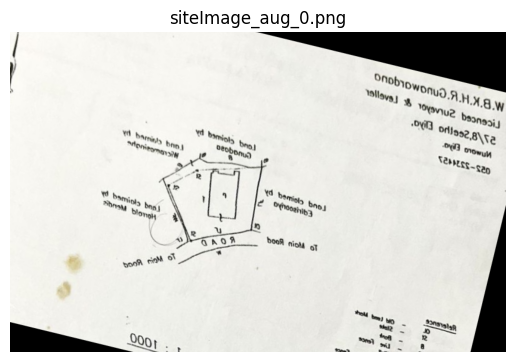

In [13]:
import cv2
import matplotlib.pyplot as plt
import json
import os

# Load augmented COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Find an image entry with an augmented file name (e.g., one containing '_aug_')
aug_image_info = next((img for img in coco_data["images"] if "_aug_" in img["file_name"]), None)
if aug_image_info:
    img_path = f"/content/augmented_images/{aug_image_info['file_name']}"
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(aug_image_info['file_name'])
        plt.axis("off")
        plt.show()
    else:
        print(f"Augmented image not found at: {img_path}")
else:
    print("No augmented image entry found in JSON.")


In [12]:
import os
print(os.listdir("/content/augmented_images"))


['siteImage1_aug_8.png', 'siteImage1_aug_0.png', 'siteImage2_aug_1.jpg', 'siteImage2_aug_9.jpg', 'siteImage_aug_8.jpg', 'siteImage1_aug_7.jpg', 'siteImage1_aug_5.jpg', 'siteImage2_aug_5.png', 'siteImage2_aug_7.jpg', 'siteImage_aug_9.png', 'siteImage_aug_5.jpg', 'siteImage_aug_8.png', 'siteImage2_aug_8.jpg', 'siteImage_aug_2.png', 'siteImage1_aug_4.jpg', 'siteImage1_aug_3.png', 'siteImage1_aug_7.png', 'siteImage_aug_5.png', 'siteImage2_aug_6.jpg', 'siteImage2_aug_6.png', 'siteImage_aug_4.jpg', 'siteImage2_aug_4.jpg', 'siteImage2_aug_4.png', 'siteImage_aug_4.png', 'siteImage_aug_9.jpg', 'siteImage2_aug_0.png', 'siteImage1_aug_2.png', 'siteImage1_aug_1.jpg', 'siteImage_aug_2.jpg', 'siteImage2_aug_1.png', 'siteImage_aug_6.png', 'siteImage2_aug_2.jpg', 'siteImage_aug_1.jpg', 'siteImage_aug_7.png', 'siteImage2_aug_5.jpg', 'siteImage1_aug_5.png', 'siteImage_aug_0.png', 'siteImage1_aug_2.jpg', 'siteImage1_aug_4.png', 'siteImage2_aug_7.png', 'siteImage2_aug_2.png', 'siteImage1_aug_1.png', 'site

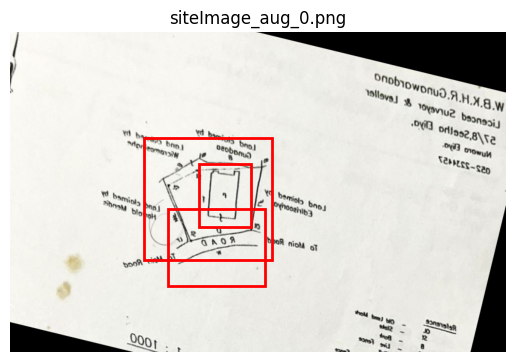

In [15]:
import cv2
import matplotlib.pyplot as plt
import json
import os

# Load augmented COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Pick one augmented image (look for '_aug_' in the filename)
aug_image_info = next((img for img in coco_data["images"] if "_aug_" in img["file_name"]), None)
if aug_image_info is not None:
    img_path = f"/content/augmented_images/{aug_image_info['file_name']}"
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == aug_image_info["id"]]

        plt.imshow(img)
        ax = plt.gca()
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))
        plt.title(aug_image_info['file_name'])
        plt.axis("off")
        plt.show()
    else:
        print(f"Augmented image not found at: {img_path}")
else:
    print("No augmented image entry found in JSON.")


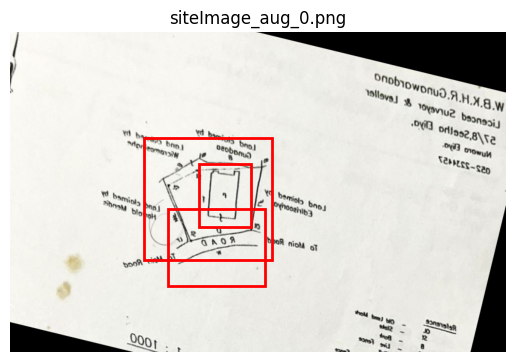

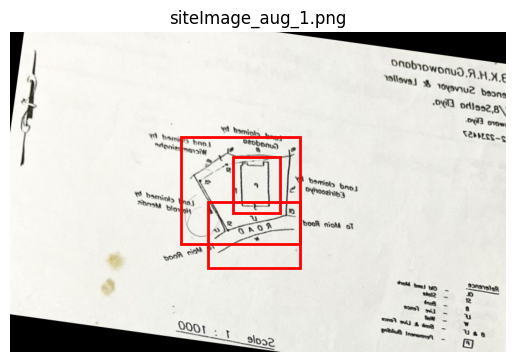

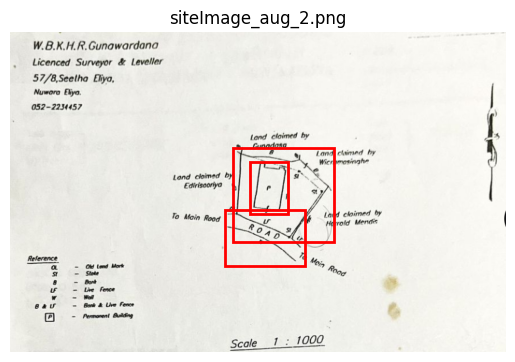

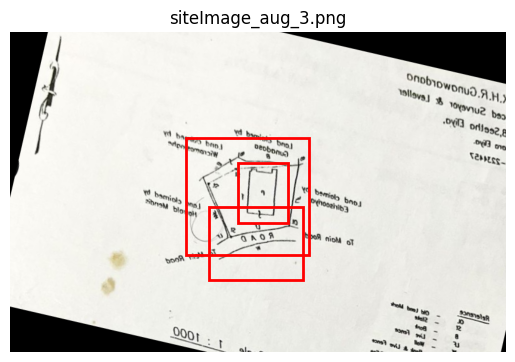

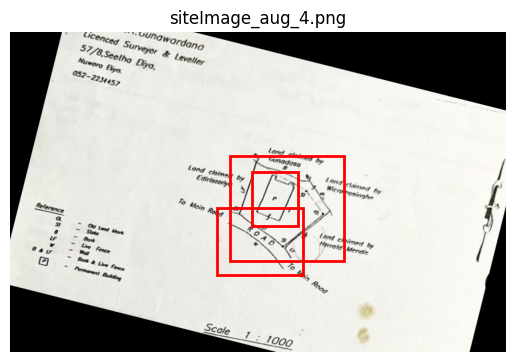

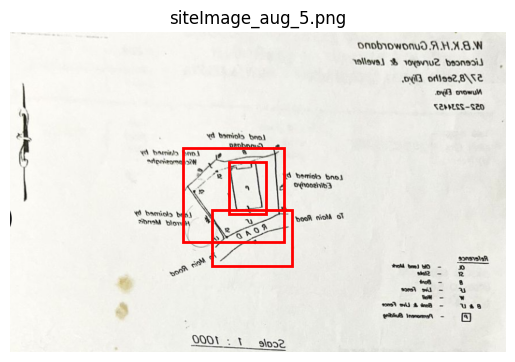

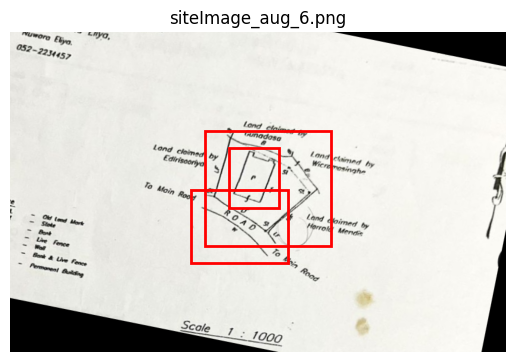

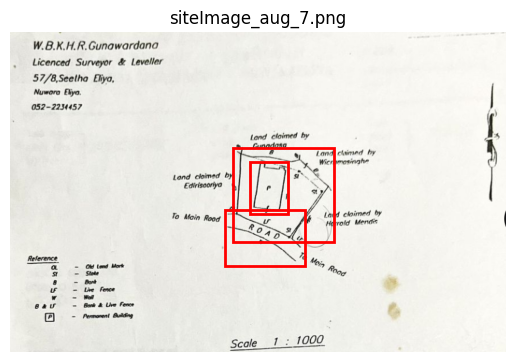

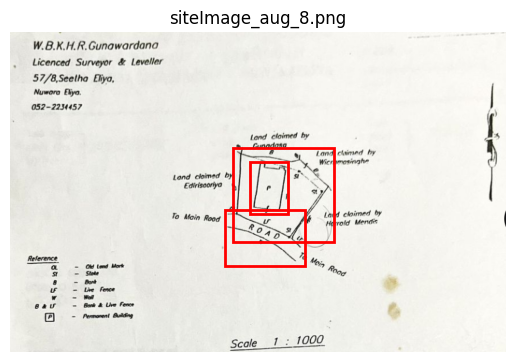

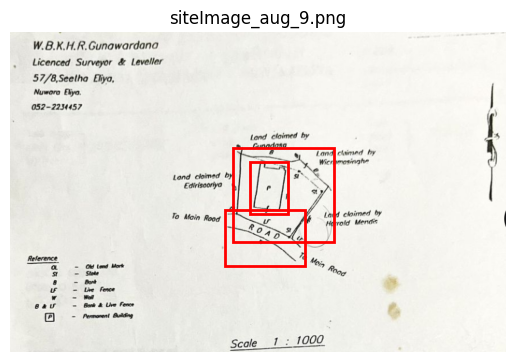

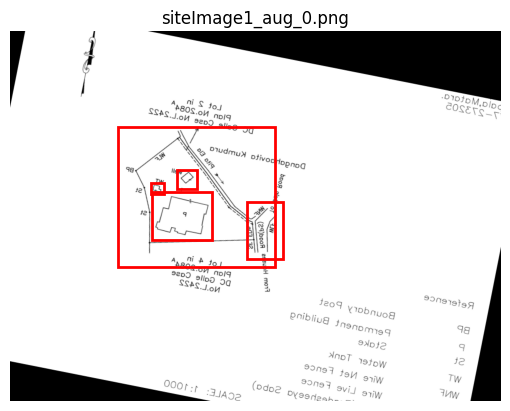

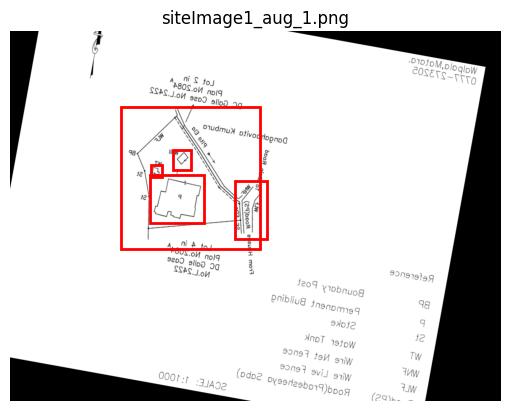

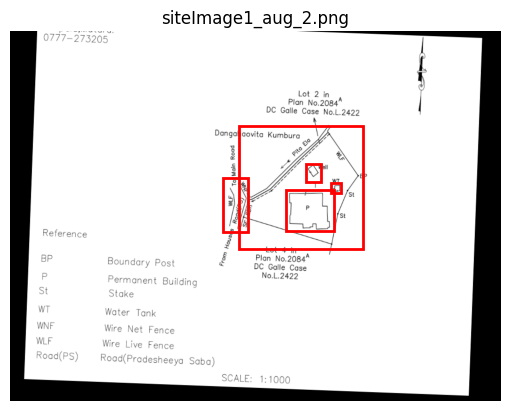

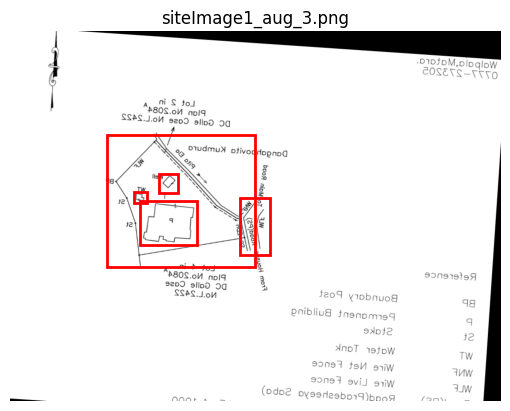

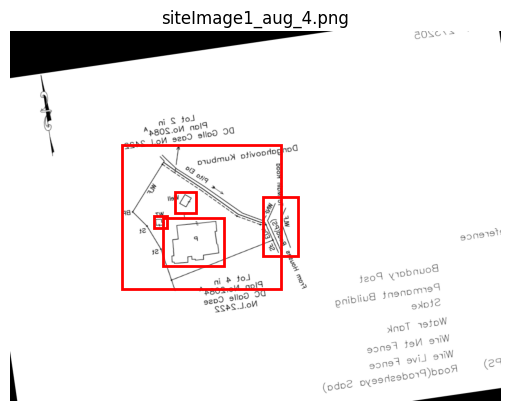

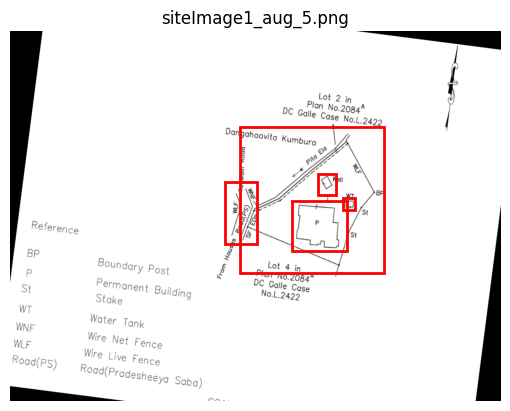

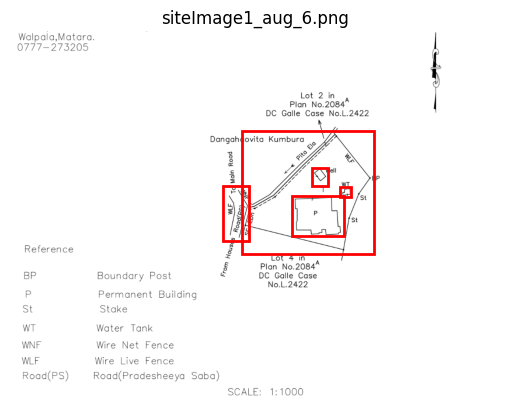

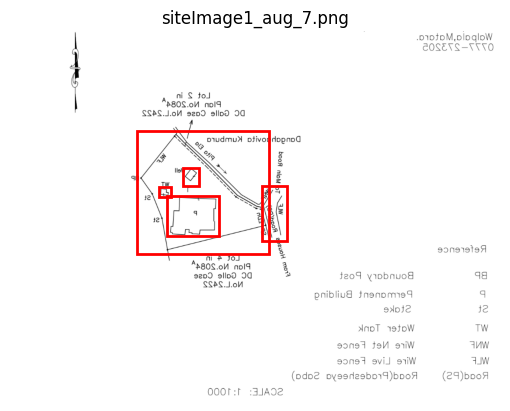

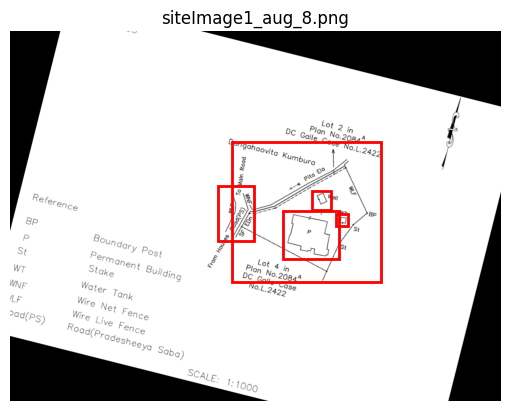

KeyboardInterrupt: 

In [16]:
import cv2
import matplotlib.pyplot as plt
import json
import os

# Load augmented COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Loop through the augmented images in the JSON and display them
for aug_image_info in coco_data["images"]:
    if "_aug_" in aug_image_info["file_name"]:  # Only show augmented images
        img_path = f"/content/augmented_images/{aug_image_info['file_name']}"

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

            annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == aug_image_info["id"]]

            # Plot image with bounding boxes
            plt.imshow(img)
            ax = plt.gca()
            for ann in annotations:
                x, y, w, h = ann["bbox"]
                ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))

            plt.title(aug_image_info['file_name'])
            plt.axis("off")
            plt.show()
        else:
            print(f"Augmented image not found at: {img_path}")


In [1]:
import json
import os

# Path to your images and augmented labels
images_dir = '/content/augmented_images'  # Adjust as needed
output_dir = '/content/yolo_annotations'  # Folder to store YOLO annotations
os.makedirs(output_dir, exist_ok=True)

# Load COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Example mapping of COCO categories to YOLO class ids
class_mapping = {
    "class_name_1": 0,  # Replace with actual class names and corresponding IDs
    "class_name_2": 1,
    # Add more classes as needed
}

# Convert COCO annotations to YOLO format
for image_info in coco_data["images"]:
    img_name = image_info["file_name"]
    img_width = image_info["width"]
    img_height = image_info["height"]

    # Prepare path for the YOLO annotation file
    yolo_annotation_file = os.path.join(output_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    # Get annotations for the current image
    annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == image_info["id"]]

    # Open the YOLO annotation file for writing
    with open(yolo_annotation_file, 'w') as f:
        for ann in annotations:
            # Extract the class and bounding box
            class_name = coco_data["categories"][ann["category_id"] - 1]["name"]
            class_id = class_mapping.get(class_name, -1)  # Map class name to YOLO class ID

            # COCO bbox format [x, y, width, height]
            x, y, width, height = ann["bbox"]

            # Normalize bbox coordinates to YOLO format
            x_center = (x + width / 2) / img_width
            y_center = (y + height / 2) / img_height
            normalized_width = width / img_width
            normalized_height = height / img_height

            # Write the YOLO annotation in the text file
            f.write(f"{class_id} {x_center} {y_center} {normalized_width} {normalized_height}\n")

    print(f"Processed {img_name}")

print("Conversion completed!")


Processed siteImage.png
Processed siteImage1.png
Processed siteImage2.png
Processed siteImage_aug_0.png
Processed siteImage_aug_1.png
Processed siteImage_aug_2.png
Processed siteImage_aug_3.png
Processed siteImage_aug_4.png
Processed siteImage_aug_5.png
Processed siteImage_aug_6.png
Processed siteImage_aug_7.png
Processed siteImage_aug_8.png
Processed siteImage_aug_9.png
Processed siteImage1_aug_0.png
Processed siteImage1_aug_1.png
Processed siteImage1_aug_2.png
Processed siteImage1_aug_3.png
Processed siteImage1_aug_4.png
Processed siteImage1_aug_5.png
Processed siteImage1_aug_6.png
Processed siteImage1_aug_7.png
Processed siteImage1_aug_8.png
Processed siteImage1_aug_9.png
Processed siteImage2_aug_0.png
Processed siteImage2_aug_1.png
Processed siteImage2_aug_2.png
Processed siteImage2_aug_3.png
Processed siteImage2_aug_4.png
Processed siteImage2_aug_5.png
Processed siteImage2_aug_6.png
Processed siteImage2_aug_7.png
Processed siteImage2_aug_8.png
Processed siteImage2_aug_9.png
Conver

In [2]:
!pip install opencv-python


In [3]:
import os
import json
import cv2

# Function to convert COCO bounding box to YOLO format
def convert_to_yolo_format(coco_bbox, image_width, image_height):
    x, y, w, h = coco_bbox
    # Convert to YOLO format (normalized coordinates)
    x_center = (x + w / 2) / image_width
    y_center = (y + h / 2) / image_height
    width = w / image_width
    height = h / image_height
    return [x_center, y_center, width, height]

# Load COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Define the output directory for the YOLO formatted labels
output_labels_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/yolo_labels/'
os.makedirs(output_labels_dir, exist_ok=True)

# Map COCO class IDs to YOLO class IDs (you may need to adjust this mapping)
class_mapping = {0: 0}  # Example: class 0 in COCO -> class 0 in YOLO

# Process each image and its annotations
for image_info in coco_data['images']:
    image_id = image_info['id']
    image_filename = image_info['file_name']

    # Correct image path for augmented images
    img_path = f"/content/drive/MyDrive/Colab Notebooks/Dataset/augmented_images/{image_filename}"

    # Check if the image exists before processing
    if not os.path.exists(img_path):
        print(f"Warning: Image {img_path} not found. Skipping.")
        continue

    # Load the image to get its dimensions
    img = cv2.imread(img_path)
    image_height, image_width, _ = img.shape

    # Prepare YOLO annotations for this image
    yolo_annotations = []

    # Get annotations for the image
    for ann in coco_data['annotations']:
        if ann['image_id'] == image_id:
            # Map the COCO category to YOLO class (you may need to customize this mapping)
            class_id = class_mapping.get(ann['category_id'], None)
            if class_id is not None:
                # Convert the COCO bbox to YOLO format
                yolo_bbox = convert_to_yolo_format(ann['bbox'], image_width, image_height)
                yolo_annotations.append([class_id] + yolo_bbox)

    # Save YOLO annotations to a text file
    if yolo_annotations:
        yolo_txt_path = os.path.join(output_labels_dir, os.path.splitext(image_filename)[0] + '.txt')
        with open(yolo_txt_path, 'w') as f:
            for annotation in yolo_annotations:
                f.write(' '.join(map(str, annotation)) + '\n')

    print(f"Processed {image_filename}")

print("Conversion completed!")


Conversion completed!
